# Estudio de métodos de control con aproximaciones

Este estudio pertenece a la parte 2 de la práctica 1 correspondiente a la asignatura Extensiones de Machine Learning del máster de IA en la Universidad de Murcia.

El grupo de alumnos que han realizado el estudio está conformado por:

- Tomás Díaz Díaz
- Jose Antonio Sánchez Fernández

## Introducción

Este notebook explora técnicas de aprendizaje por refuerzo que requieren aproximación de funciones:
- SARSA semi-gradiente
- Deep Q-Learning (DQN)

Para la realización del estudio, se utilizará el entorno ***Gymnasium***. Ambas técnicas serán evaluadas en el escenario `CartPole-v1`, consistente en un carro que debe mantener una barra en equilibrio mediante el movimento a izquierda. El espacio de estados en este escenario es continuo y el espacio de acciones es discreto, como veremos durante la creación del entorno. Cada episodio del experimento termina cuando la barra cae o transcurren 500 pasos.

## Imports y configuración

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import pandas as pd
import gc

import torch

import sys
sys.path.append('src/')
from AgentSARSASemiGradiente import AgentSARSASemiGradiente
from AgentDeepQLearning import AgentDQLearning

## Preparación del entorno

In [41]:
# Declaramos una semilla para la reproducibilidad de los resultados y modificación del entorno CartPole
SEMILLA = 60
np.random.seed(SEMILLA) 
np.random.default_rng(SEMILLA)
torch.manual_seed(SEMILLA)
if torch.cuda.is_available(): # Si hay GPU disponible
    torch.cuda.manual_seed(SEMILLA)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Fijamos la semilla en Gymnasium
def make_env(env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    env.reset(seed=SEMILLA)
    env.action_space.seed(SEMILLA)
    env.observation_space.seed(SEMILLA)
    return env

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

gc.collect()
torch.cuda.empty_cache()

# Inicializamos el entorno de CartPole
env_name = "CartPole-v1"
sarsa_sg_env = make_env(env_name)
dql_env = make_env(env_name)

n_episodes = 500
sarsa_sg_env = gym.wrappers.RecordEpisodeStatistics(sarsa_sg_env, buffer_length=n_episodes)
dql_env = gym.wrappers.RecordEpisodeStatistics(dql_env, buffer_length=n_episodes)

# Definimos los agentes SARSA-SG y DQL
sarsa_agent = AgentSARSASemiGradiente(sarsa_sg_env, alpha=0.01, gamma=0.99, epsilon=0.1)
dql_agent = AgentDQLearning(dql_env, gamma=0.99, epsilon=0.1, lr=0.01)

# Usamos el entorno SARSA-SG como ejemplo para obtener las dimensiones del espacio de estados y acciones
state_dim = sarsa_agent.state_dim
action_dim = sarsa_agent.action_dim
print(f"Estado: {state_dim} dimensiones, Acciones: {action_dim}")
print(f"Dimensiones: {sarsa_sg_env.observation_space}")

Usando dispositivo: cpu
Estado: 4 dimensiones, Acciones: 2
Dimensiones: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


**¿Qué estamos viendo en este entorno?**

Lo que nos dice esta salida de las características del entorno es que disponemos de 4 dimensiones basadas en las variables que influyen en la localización espacial del carrito, y 2 acciones que podemos realizar con él.
Sobre las dimensiones, por la documentación del escenario concreto, sabemos que consisten en las siguientes:

| Dimensión                    |  Límites mostrados              | Tipo de dato |
|------------------------------|---------------------------------|--------------|
| Posición del carrito (x)     | [-4.8, 4.8]                     | `float32`    |
| Velocidad del carrito (v)    | [-inf, inf]                     | `float32`    |
| Ángulo del poste en radianes | [-0.41887903, 0.41887903]       | `float32`    |
| Velocidad angular del poste  | [-inf, inf]                     | `float32`    |

Estas dimensiones son las que influyen en la cantidad de estados de los que dispondrán nuestros agentes para moverse y alcanzar una política. Sin embargo, al haber variables sin un rango discreto, vemos que habrá una cantidad infinita de estados, por lo que los métodos tabulares dejan de ser viables en un escenario como este. Es por ello que utilizaremos este entorno para demostrar la funcionalidad de los métodos de control por aproximaciones.

**¿Cuál es el objetivo del entorno?**

En este escenario, el objetivo es que el agente mantenga estable el poste encima del carrito durante 500 pasos, teniendo que tomar decisiones en cada paso dados los estados en los que se encuentran el carrito y el poste. Por ello, puede haber tres situaciones que den por finalizado el escenario: 

- **Se falla el objetivo** si se alcanzan los siguientes valores en las dimensiones:
    - El ángulo del poste es mayor que ±12° (0,20944 radianes)
    - La posición del carrito es mayor que ±2.4, saliéndose de los límites de la imagen proyectada
- **Se cumple el objetivo** al alcanzar los 500 pasos con el poste sobre el carrito manteniendo las dos variables previamente mencionadas dentro de sus límites.

Inicialmente, las cuatro variables que conforman las dimensiones del escenario obtienen un valor aleatorio uniforme entre -0.05 y 0.05 (aunque esto puede ser modificado a nuestro antojo en la creación). Tras esto, el agente tomará una acción posible para mantener el poste estable dentro de los límites, ya sea empujando el carrito hacia la izquierda o hacia la derecha.

## Entrenamiento

In [43]:
sarsa_rewards, sarsa_steps, sarsa_actions, sarsa_pole_angles, sarsa_cart_positions = sarsa_agent.train(sarsa_sg_env, n_episodes=n_episodes)
dql_rewards, dql_steps, dql_actions, dql_pole_angles, dql_cart_positions = dql_agent.train(dql_env, n_episodes=n_episodes)

# Guardamos estadísticas para las gráficas
training_stats = {
    "SARSA Semi-Gradiente": {
        "rewards": sarsa_rewards,
        "steps": sarsa_steps,
        "actions": sarsa_actions,
        "pole_angles": sarsa_pole_angles,
        "cart_positions": sarsa_cart_positions
    },
    "Deep Q-Learning": {
        "rewards": dql_rewards,
        "steps": dql_steps,
        "actions": dql_actions,
        "pole_angles": dql_pole_angles,
        "cart_positions": dql_cart_positions
    }
}

Lo primero que debemos abordar es la cuestión de qué estadísticas hemos escogido como métricas del entrenamiento y rendimiento de ambos agentes, y posteriormente analizaremos los resultados de cada uno utilizando dichas métricas. Las medidas escogidas para este estudio han sido las siguientes:

- **Recompensa alcanzada por episodio** (acompañada de los **pasos de duración del episodio**).
- **Acciones tomadas** por el agente.
- **Ángulos del poste** por cada episodio.
- **Posiciones del carrito** por episodio.

In [44]:
for i in range(5):
    print(f"Episodio {i+1}:")
    print(f"  SARSA Semi-Gradiente: recompensa {sarsa_rewards[i]}, pasos {sarsa_steps[i]}")
    print(f"  Deep Q-Learning: recompensa {dql_rewards[i]}, pasos {dql_steps[i]}")

Episodio 1:
  SARSA Semi-Gradiente: recompensa 9.0, pasos 9
  Deep Q-Learning: recompensa 14.0, pasos 14
Episodio 2:
  SARSA Semi-Gradiente: recompensa 9.0, pasos 9
  Deep Q-Learning: recompensa 12.0, pasos 12
Episodio 3:
  SARSA Semi-Gradiente: recompensa 9.0, pasos 9
  Deep Q-Learning: recompensa 11.0, pasos 11
Episodio 4:
  SARSA Semi-Gradiente: recompensa 9.0, pasos 9
  Deep Q-Learning: recompensa 15.0, pasos 15
Episodio 5:
  SARSA Semi-Gradiente: recompensa 8.0, pasos 8
  Deep Q-Learning: recompensa 12.0, pasos 12


Como podemos ver, los primeros elementos de los datos obtenidos de *rewards* y de *steps* son exactamente los mismos en ambos agentes. Esto ocurre debido a que la recompensa que el agente obtiene en cada paso es de valor 1, incluyendo el paso que termina el episodio, así alcance su objetivo o no, ya que, como el objetivo es mantener el poste estable **la mayor cantidad de tiempo posible**, la recompensa debe ir directamente relacionada con el número de pasos que consigue aguantar el agente con el poste dentro de los límites no terminales. Esto no sucede en entornos como `FrozenLake-v1` visto en el estudio de métodos tabulares debido a que se obtiene una única recompensa final, o en entornos donde las recompensas no son constantes por paso.

Por este motivo, no se implementará ninguna gráfica relacionada con la duración temporal del episodio, sino que dicha estadística irá implícita en la recompensa obtenida y los cálculos extraídos sobre la misma.

## Evaluación

### Definición de funciones

In [45]:
def get_moving_avgs(arr, window, convolution_mode):
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window


def plot_rewards_full(training_stats, title="Comparación de recompensas", rolling_window=100):
    _, axs = plt.subplots(1, 2, figsize=(18, 6))

    # Gráfico 1: Recompensa total por episodio
    for agent_name, stats in training_stats.items():
        axs[0].plot(stats["rewards"], label=agent_name)
    axs[0].set_title(f"{title} (Total)")
    axs[0].set_xlabel("Episodio")
    axs[0].set_ylabel("Recompensa")
    axs[0].grid(True)
    axs[0].legend()

    # Gráfico 2: Recompensa media móvil
    for agent_name, stats in training_stats.items():
        moving_avg = get_moving_avgs(stats["rewards"], rolling_window, 'valid')
        axs[1].plot(moving_avg, label=f"{agent_name} (Media móvil)")
    axs[1].set_title(f"{title} (Media móvil con ventana = {rolling_window})")
    axs[1].set_xlabel("Episodio")
    axs[1].set_ylabel("Recompensa")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()


def plot_action_distribution(training_stats, title="Distribución de acciones por agente"):
    """
    Grafica la distribución de acciones para múltiples agentes a partir de training_stats.
    
    Parámetros:
    - training_stats: dict con estadísticas de entrenamiento, debe contener "actions" por agente.
    - title: str, título del gráfico.
    """
    agent_names = list(training_stats.keys())
    action_labels = sorted(set(a for stats in training_stats.values() for a in stats["actions"]))
    num_actions = len(action_labels)

    # Contar acciones por agente
    action_distributions = []
    for stats in training_stats.values():
        counts = [stats["actions"].get(a, 0) for a in action_labels]
        action_distributions.append(counts)

    # Posiciones para agrupamiento de barras
    x = np.arange(num_actions)
    width = 0.8 / len(agent_names)  # Ancho de cada barra

    # Crear gráfico
    plt.figure(figsize=(8, 5))
    for i, (agent_name, counts) in enumerate(zip(agent_names, action_distributions)):
        offset = (i - len(agent_names)/2) * width + width/2
        plt.bar(x + offset, counts, width=width, label=agent_name)

    plt.xticks(x, ["Izquierda", "Derecha"])
    plt.xlabel("Acción")
    plt.ylabel("Frecuencia")
    plt.title(title)
    plt.grid(True, axis='y')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

def plot_variable_summary(training_stats, variable_key, title):
    agent_names = list(training_stats.keys())
    summary_stats = {"mean": [], "max": [], "min": [], "std": []}

    for agent in agent_names:
        episode_dict = training_stats[agent][variable_key]
        
        # Extraemos todos los valores de todos los episodios
        all_values = []
        for ep_vals in episode_dict.values():
            all_values.extend(ep_vals)
        
        # Calculamos estadísticas
        summary_stats["mean"].append(np.mean(all_values))
        summary_stats["max"].append(np.max(all_values))
        summary_stats["min"].append(np.min(all_values))
        summary_stats["std"].append(np.std(all_values))

    # Posiciones para las barras agrupadas
    x = np.arange(len(agent_names))
    width = 0.2

    _, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x - 1.5*width, summary_stats["mean"], width=width, yerr=summary_stats["std"],
           label="Media", capsize=6)
    ax.bar(x - 0.5*width, summary_stats["max"], width=width, label="Máximo")
    ax.bar(x + 0.5*width, summary_stats["min"], width=width, label="Mínimo")

    ax.set_xticks(x)
    ax.set_xticklabels(agent_names)
    ax.set_ylabel("Valor")
    ax.set_title(title)
    ax.legend()
    ax.grid(True, axis="y")
    plt.tight_layout()
    plt.show()


def plot_variable_over_episode(stats_dict, variable_name, title=""):
    # Encontrar el episodio con la mayor recompensa para cada agente
    max_reward_episodes = {
        agent_name: np.argmax(stats["rewards"]) for agent_name, stats in stats_dict.items()
    }
    
    plt.figure(figsize=(10, 4))
    for agent_name, stats in stats_dict.items():
        # Obtener el índice del episodio con la mayor recompensa
        episode_idx = max_reward_episodes[agent_name]
        values = stats[variable_name].get(episode_idx, [])
        plt.plot(values, label=f"{agent_name} (Episodio {episode_idx})")
    
    plt.title(f"{title} en el episodio con mayor recompensa")
    plt.xlabel("Paso del episodio")
    plt.ylabel(title)
    plt.grid(True)
    plt.legend()
    plt.show()


### Análisis de gráficas

#### Recompensas

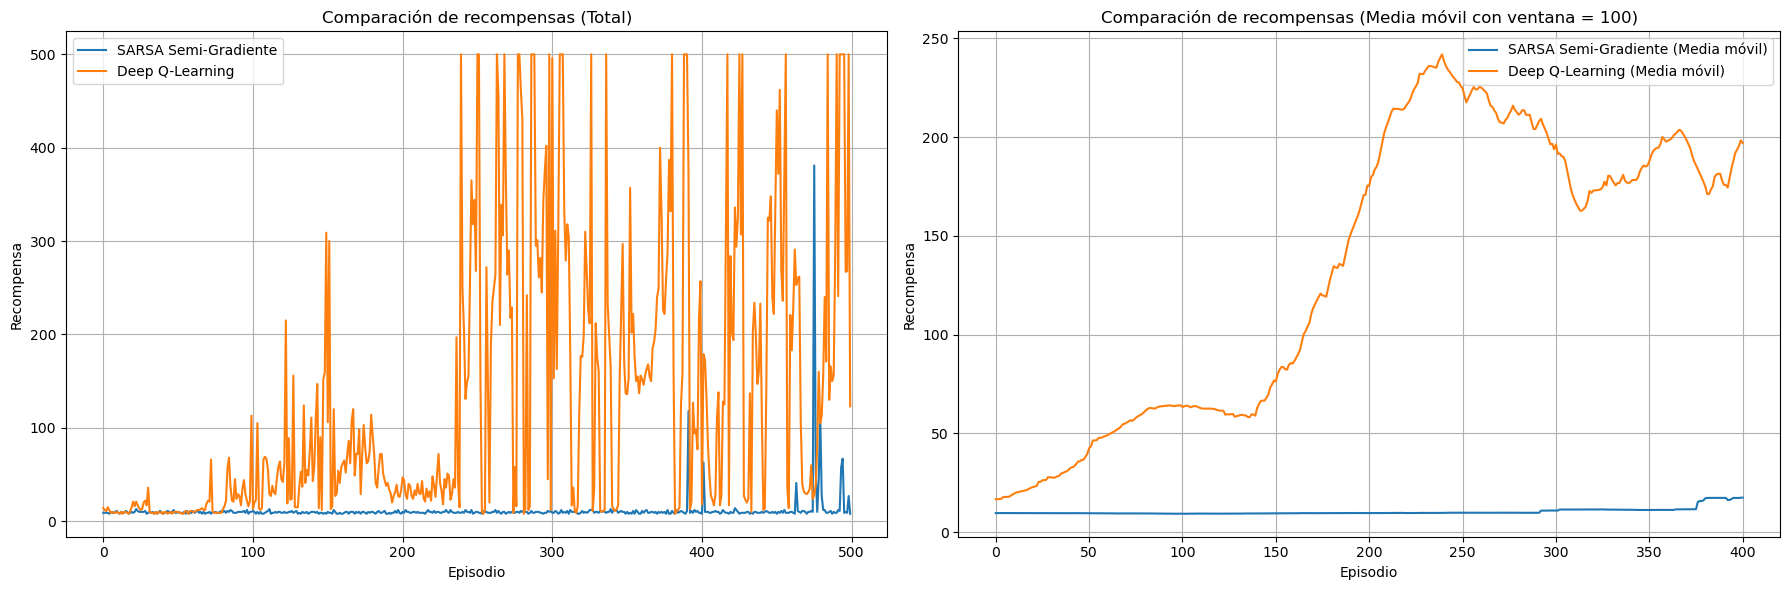

In [46]:
plot_rewards_full(training_stats, title="Comparación de recompensas")

Las gráficas que estamos viendo contienen una representación sobre la recompensa obtenida por el agente durante los 500 episodios sobre los que se extiende este experimento. Vamos a explicar brevemente cada una y daremos un análisis de los datos que se pueden obtener de los valores de recompensa tras la ejecución de todos los episodios.

---------------------------------------------------------------------------------------------------------------------------------------------------------

La gráfica izquierda muestra la recompensa obtenida tal y como se acumula en cada episodio, sin retoques ni cálculos adicionales. Esto nos permite observar altibajos concretos o analizar grandes diferencias entre los episodios transcurridos.

Sobre **SARSA Semi-Gradiente**, podemos ver que su línea es estable y consistente pero manteniendo un nivel de recompensa mediocre, con ligeras subidas en episodios concretos como algunos cerca del 400 y otros cerca del 500. Esto puede darnos a entender que presenta un comportamiento más conservador y no da pie a explorar opciones más interesantes en cuanto al cálculo de las variables y realización de acciones. Lo más llamativo es que no alcanza el máximo en ningún momento, fracasando en todos los episodios sin lograr el objetivo marcado.

En cambio, el agente **Deep Q-Learning** muestra una clarísima mejora conforma avanza el número de episodios, dándose un notable incremento de las recompensas habituales a partir del episodio 100 y finalmente una mejora abismal sobre el 250. Sin embargo, este agente presenta una variabilidad muy alta, ya que, a pesar de esta mejora, en algunos episodios aún obtiene resultados muy pobres, lo que puede entenderse como una tendencia a la exploración de los límites de las acciones una vez alcanzado el objetivo en un epsiodio anterior. Este objetivo, además, se logra en algunos picos claramente visibles, por lo que podemos decir que este agente sí ha sido capaz de completar el desafío propuesto, al menos en algunos episodios concretos.

---------------------------------------------------------------------------------------------------------------------------------------------------------

En cuanto a la gráfica derecha, vemos que se varía ligeramente el tipo de dato utilizado ya que, en lugar de las recompensas tal cual, se utiliza una ventana de 100 episodios para calcular la media móvil. Esta métrica, explicada brevemente, calcula el promedio de nuestras recompensas mediante una ventana deslizante de tamaño fijo, lo que permite suavizar las fluctuaciones tan bruscas de los datos (como las que ocurren en la gráfica izquierda, que nos complica un poco la interpretación de los resultados) y nos ayuda a entender la tendencia general del agente.

Comentando brevemente los resultados obtenidos para cada agente:

Podemos ver que **SARSA Semi-Gradiente** tiene una pendiente casi nula, mejorando muy ligeramente al final, cerca de los últimos 50 episodios, aunque la media móvil es de un valor irrisorio ya que no supera los 25 en ningún momento, por lo que podemos decir que raramente tiene episodios que podríamos considerar "largos" y no logra mantener el poste en equilibrio un número decentemente grande de pasos.

Por otro lado, el agente **Deep Q-Learning** mantiene una tendencia ligeramente ascendente con un pequeño parón sobre el episodio 100, aunque, a partir del 140, aproximadamente, su curva de aprendizaje obtiene una marcadísima pronunciación positiva con cierta variabilidad visible en la pequeña bajada a partir de los episodios justamente anteriores al 250 que denota que su rendimiento decae ligeramente aunque se acabe recuperando en las últimas etapas del experimento, lo que indica que el agente ha sido capaz de alcanzar un conocimiento más que notable sobre las acciones convenientes dada la situación del poste y del carro en cada paso.

------------------------------

Debido a estos resultados, podemos decir que SARSA presenta una mejora leve pero muchísimo más modesta que DQL, el cual aprende mucho mejor a largo plazo a pesar de ciertas etapas con resultados variables. Esto nos indica que SARSA no está explorando lo suficiente como para realizar un aprendizaje significativo, mientras que DQL sí lo hace, aunque su ligera variabilidad explicaría su posible mejora centrándose un poco más en la explotación que en la exploración a pesar de que sus resultados sean bastante buenos.

In [47]:
stats_data = {
    "Agente": ["SARSA Semi-Gradiente", "Deep Q-Learning"],
    "Máximo": [max(sarsa_rewards), max(dql_rewards)],
    "Mínimo": [min(sarsa_rewards), min(dql_rewards)],
    "Media": [round(np.mean(sarsa_rewards), 2), round(np.mean(dql_rewards), 2)],
    "Desviación Típica": [round(np.std(sarsa_rewards), 2), round(np.std(dql_rewards), 2)]
}

stats_df = pd.DataFrame(stats_data)

display(stats_df)

,Agente,Máximo,Mínimo,Media,Desviación Típica
0,SARSA Semi-Gradiente,381.0,8.0,11.40,18.57
1,Deep Q-Learning,500.0,8.0,129.74,143.99


Si calculamos valores estadísticos relacionados con las recompensas obtenemos los datos mostrados justo arriba. Analizándolos por separado:

- **Recompensa máxima**:
    - SARSA logra un máximo de 381, que no está mal, pero nos indica que nunca logra completar satisfactoriamente el objetivo.
    - DQL, por contra, sí que cumple el objetivo al obtener un máximo de 500, la puntuación deseada.

- **Recompensa mímima**:
    - En esta métrica, ambos agentes obtienen un mínimo de 8, por lo que podemos afirmar que ambos tienen un comienzo muy similar en cuanto a desempeño.
- **Recompensa media**:
    - SARSA tiene una media muy baja (11.4), lo que implica que en la mayoría de los episodios no logra mantener el equilibrio más de unos pocos pasos.
    - DQL, sin embargo, tiene una media mucho más elevada, lo que refleja que, en general, logra episodios mucho más largos que su rival.
- **Desviación típica**:
    - SARSA es mucho más limitado, aunque su desviación tan inferior de 18.57 muestra que es bastante más estable que DQL.
    - DQL tiene una dispersión altísima con 143.99, lo que indica gran variabilidad en el desempeño. Esto queda claramente representado en la gráfica de recompensas sin suavizar.

Como resumen final de este apartado, podemos decir que, a pesar de un comienzo más o menos parejo, DQL es mucho mejor que SARSA, especialmente en el largo plazo, con una variabilidad bastante alta que puede indicar una exploración demasiado agresiva o una posible mejora de su ajuste de red. SARSA, por otro lado, es más estable pero mucho más lenta, y no consigue explotar el entorno debido a, posiblemente, una configuración que no favorece la exploración.

#### Acciones

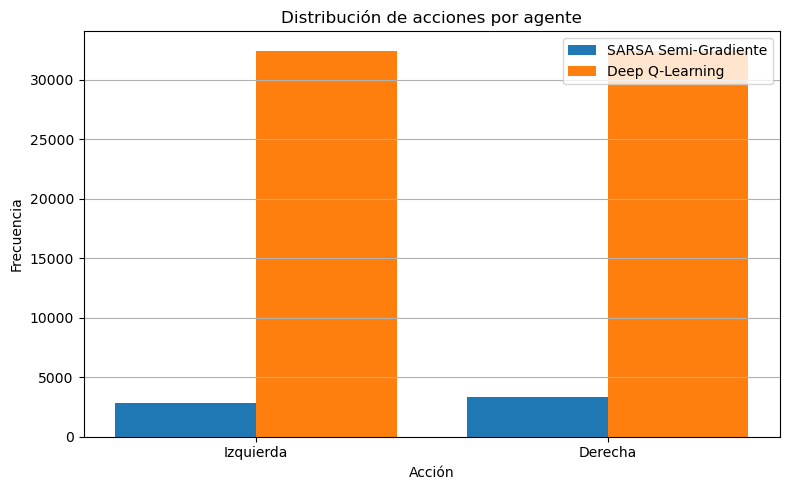

In [48]:
plot_action_distribution(training_stats)

Esta gráfica muestra cuántas veces cada agente ha tomado una acción específica durante todos los episodios de entrenamiento. En el entorno *CartPole-V1*, las acciones disponibles son: `Mover el carrito hacia la izquierda` y `Mover el carrito hacia la derecha`. Analizando el comportamiento de cada agente:

- **SARSA Semi-Gradiente** realiza aproximadamente 3000 acciones en total para cada tipo de acción, esto provoca que la distribución sea casi simétrica, lo que sugiere un comportamiento balanceado en cuanto a las decisiones de movimiento. Este bajo número tan llamativo puede indicar que el agente no ha desarrollado una política fuerte o especializada y tiende a actuar de forma más uniforme, lo que está alineado con su baja recompensa media y lenta mejora observada en los gráficos anteriores y conlleva como consecuencia directa un aprendizaje más lento y con peor rendimiento.

- **Deep Q-Learning** realiza algo más de 30000 acciones para ambas acciones, mostrando un enfoque de simetría similar al de su rival. El número total de acciones que multiplica por 10 a SARSA es fácilmente explicable debido a que los episodios de este agente, como vimos en los gráficos anteriores, tienden a ser de mayor duración y, al parecer, menos aleatorios, de lo que se puede extraer que el agente ha aprendido unas políticas determinadas que le ayudan a corregir mejor la inestabilidad del entorno.

#### Dimensiones

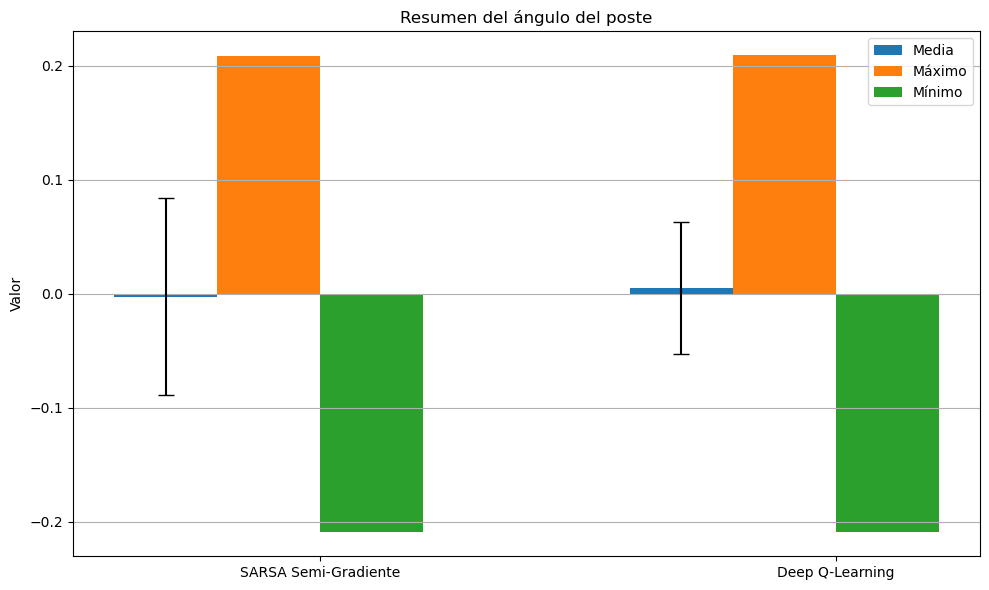

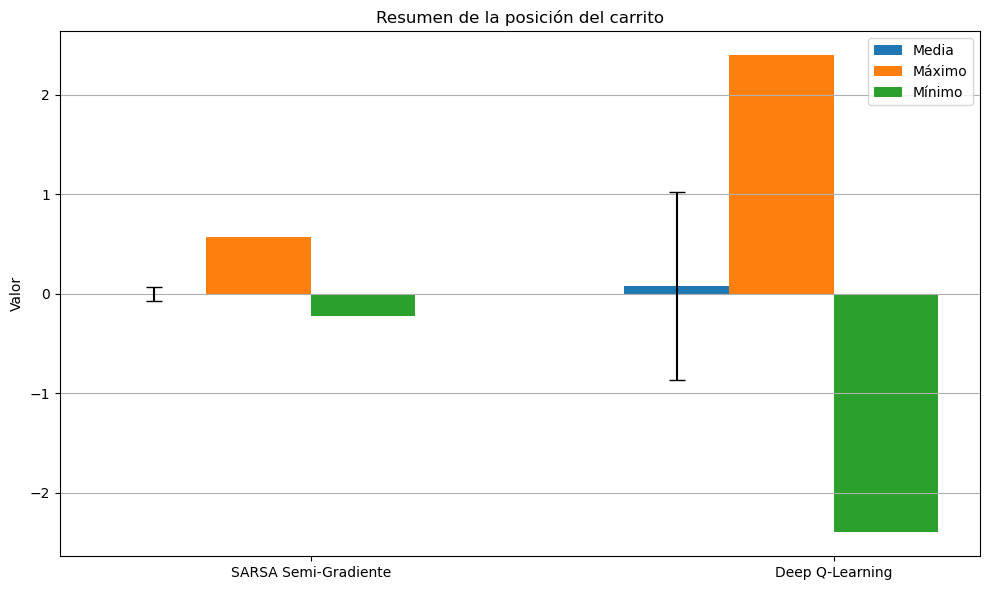

In [49]:
plot_variable_summary(training_stats, "pole_angles", title="Resumen del ángulo del poste")
plot_variable_summary(training_stats, "cart_positions", title="Resumen de la posición del carrito")

Estas dos gráficas dan un resumen del comportamiento de las variables más importantes de este entorno, las que reflejan la posible terminación del objetivo: el **ángulo del poste** y la **posición del carrito**, mostrando para cada una las medias junto a las desviaciones típicas, el máximo y el mínimo de forma diferenciada para cada agente. Vamos a analizar las gráficas por separado, comentando la variable analizada y su influencia sobre el rendimiento de los agentes.

-----------------------------------------------------------------------------------------

Comenzando por la gráfica relacionada con el ángulo del poste:

- **SARSA Semi-Gradiente**:
    - La media está en prácticamente 0, por lo que podemos decir que el poste se mantiene vertical de manera bastante habitual.
    - Su desviación típica muestra que hay mucha variabilidad pero no de una forma tan excesiva. Esto parece ser indicativo de que cuando el poste cae, lo hace de manera brusca, lo que quiere decir que en los casos donde el poste cae suele hacerlo con un incremento de su ángulo muy repentino y grande.
    - La oscilación es similar hacia ambos lados, superando el mínimo de la prueba. Esto nos indica que hay algún caso en el que el poste cae por el lado derecho y otro en el que cae por el lado izquierdo.

- **Deep Q-Learning**:
    - La media es similar a SARSA con una muy ligera tendencia positiva.
    - La desviación parece algo menor que en el caso anterior, por lo que podemos afirmar que DQL muestra un mayor control sobre el ángulo del poste, con algo menos de oscilación y mayor estabilidad, lo que coincide con su rendimiento mostrado anteriormente.
    - Se repiten los valores máximo y mínimo, por lo que la conclusión de que el poste cae en algún momento sobre cada lado se repite.

----------------------------------------------------------------------------------------

Analizando ahora la segunda gráfica, la que indica el movimiento seguido habitualmente por el carrito:

- **SARSA Semi-Gradiente**:
    - La media de 0 nos indica que, generalmente, el carrito apenas se mueve del centro.
    - La desviación típica refleja esto mismo, mostrando que hay muy poco movimiento del carrito. Esto puede venir influenciado, además, por el hecho de que el poste caiga tan rápidamente y los episodios no sean extensos.
    - El valor máximo es bastante superior al mínimo, lo que indica que hay mayor fuerza en el desplazamiento hacia la derecha que hacia la izquierda, al menos en un caso.

- **Deep Q-Learning**:
    - La media es mínimamente positiva, lo que indica que el carrito suele estar más tiempo en el lado derecho del eje que en el izquierdo. Esto puede indicar que los movimientos hacia la derecha influyen en mayor medida a la posición del carrito, ya sea por utilizar mayor fuerza o alcanzar mayor velocidad hacia ese lado.
    - La desviación es mucho mayor que en el caso de SARSA debido a que viaja más distancia, probablemente debido a la alta duración de los episodios tras la mejora sustancial contemplada en los primeros gráficos.
    - El rango de movimiento es muchísimo mayor, alcanzando el límite en algún momento. Esto refleja que es bastante posible que algunos episodios hayan terminado por incumplir la condición de mantener el carrito en el rango [-2.4, 2.4], que, oportunamente, son el mínimo y máximo mostrado por el agente en esta variable.

----------------------------------------

Como conclusión de este apartado, podemos decir que DQL demuestra un control más avanzado del entorno, permitiéndose recorrer más espacio sin comprometer el equilibrio del poste, mientras que SARSA mantiene políticas más conservadoras pero menos efectivas.

#### Análisis de un episodio

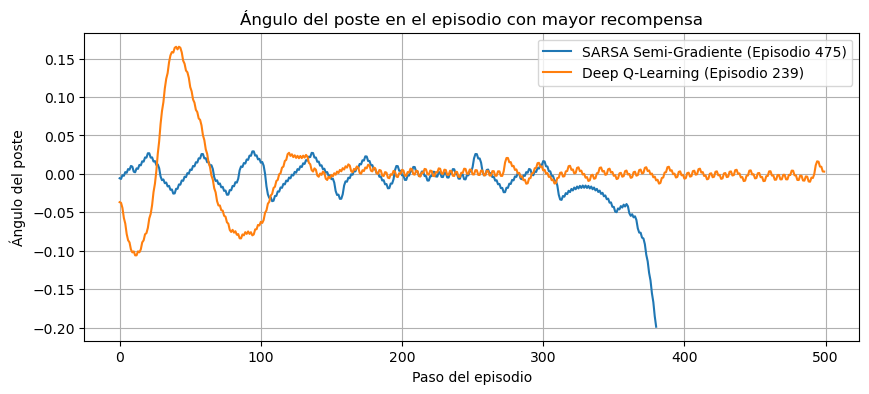

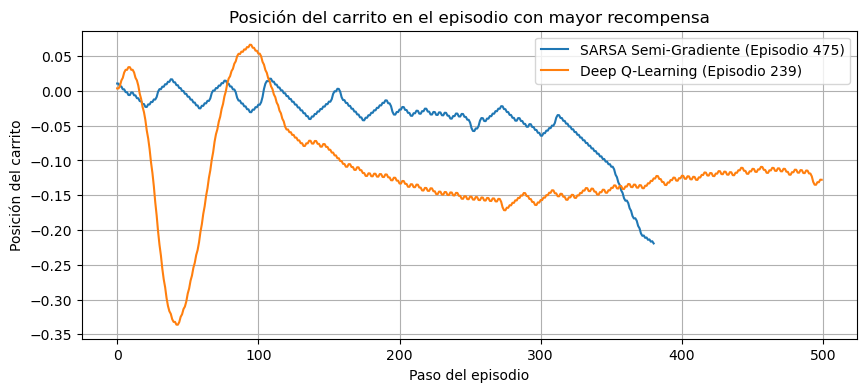

In [50]:
plot_variable_over_episode(training_stats, variable_name="pole_angles", title="Ángulo del poste")
plot_variable_over_episode(training_stats, variable_name="cart_positions", title="Posición del carrito")

Estas últimas gráficas muestran el comportamiento del ángulo del poste y la posición del carrito durante el episodio con mayor recompensa alcanzado por cada agente, que es el 475 para SARSA Semi-Gradiente y el 239 para Deep Q-Learning.

---------------------------------------------------------------------------------------------------------------------------------------------------------

La primera de ellas es la gráfica superior, que refleja el **ángulo del poste** durante dichos episodios. Comentando brevemente el transcurso de dicha variable:

- Vemos que, en el caso de **SARSA Semi-Gradiente**, muestra oscilaciones suaves y frecuentes en torno al eje 0, manteniéndose bastante cerca del equilibrio durante la primera mitad del episodio. A partir del paso 350 aproximadamente, el ángulo comienza a desestabilizarse rápidamente, lo que indica que el agente pierde el control del poste, terminando con una caída abrupta hasta -0.2 radianes, que coincide con el final prematuro del episodio.

- Sin embargo, para el agente Deep Q-Learning, el ángulo del poste comienza con oscilaciones de mayor amplitud, especialmente durante los primeros 100 pasos, donde se observan variaciones más marcadas (con picos de hasta 0.16 radianes). Sin embargo, tras este arranque más inestable, el agente logra estabilizar el ángulo en torno al eje Y, con oscilaciones cada vez más suaves y contenidas. A diferencia del episodio anterior, aquí no se evidencia una pérdida crítica de control, sino una tendencia progresiva a la estabilización, manteniéndose cerca del equilibrio hasta el final del episodio, lo que refleja un desempeño competente, aunque con un inicio algo más errático que SARSA.

---------------------------------------------------------------------------------------------------------------------------------------------------------

Comentando brevemente la segunda de las gráficas en relación a la posición del carrito:

- Para el episodio de **SARSA Semi-Gradiente**, el carrito se mantiene muy cerca del centro durante casi todo el episodio, moviéndose entre -0.25 y +0.1, demuestra una posición estable que mantiene muy cerca del centro durante casi todo el episodio. Esto sugiere un control más limitado o una tendencia a evitar situaciones complicadas.

- En cuanto a la posición del carrito con **Deep Q-Learning**, observamos un comportamiento inicial mucho más oscilante y pronunciado que en el caso de SARSA, con una caída brusca alrededor del paso 50 que llega hasta -0.35. Posteriormente, el carrito logra estabilizar su desplazamiento en una zona más negativa (entre -0.10 y -0.15), aunque sin volver nunca completamente al centro. Este patrón sugiere que el agente adopta una estrategia donde compensa el ángulo del poste permitiendo cierto desplazamiento sostenido hacia el lado izquierdo del entorno, lo que puede interpretarse como una política adaptativa. El control logrado es suficiente para sostener el poste en pie, y vemos que consigue una estabilidad posicional envidiable hasta que acaba el episodio. Lo que podemos entender de este caso es que la política seguida por el agente es suficientemente exploratoria y explota perfectamente las acciones una vez logra la estabilidad más o menos deseada.

---------------------------------------------------------------------------------------------------------------------------------------------------------

En estos episodios, se ha demostrado que **Deep Q-Learning es más efectivo y robusto que SARSA Semi-Gradiente**. Aunque el carrito se desplaza bastante, DQL logra mantener el equilibrio del poste durante los 500 pasos del episodio, mientras que SARSA falla antes. Esto confirma y refuerza las conclusiones obtenidas en anteriores apartados, donde se mencionaba que DQL ha aprendido estrategias más sofisticadas, tolerando movimientos complejos del sistema físico sin comprometer la estabilidad, al contrario que SARSA.